In [2]:
import os
from rdkit import Chem
from rdmc import RDKitMol

from rdmc.conformer_generation.ts_generators import TSConformerGenerator
from rdmc.conformer_generation.ts_guessers import TSEGNNGuesser, RMSDPPGuesser, AutoNEBGuesser, TSGCNGuesser
from rdmc.conformer_generation.ts_optimizers import SellaOptimizer, OrcaOptimizer
from rdmc.conformer_generation.ts_verifiers import XTBFrequencyVerifier, OrcaIRCVerifier
from rdmc.conformer_generation.pruners import CRESTPruner, TorsionPruner

from rdmc.view import interactive_conformer_viewer
from rdmc.external.xtb_tools.opt import run_xtb_calc

No GeoMol installation detected. Skipping import...


In [17]:
# specify reaction

# rxn_smiles = '[C:11]1([H:23])([H:24])[C:12]([H:25])([H:26])[C:13]([H:27])([H:28])[C:14]([H:29])=[C:15]([H:30])[C:16]1([H:31])[H:32].[c:1]1([H:17])[c:2]([H:18])[c:3]([H:19])[c:4]([C:7](=[O:8])[O:9][O:10][H:22])[c:5]([H:20])[c:6]1[H:21]>>[C:11]1([H:23])([H:24])[C:12]([H:25])([H:26])[C:13]([H:27])([H:28])[C:14]2([H:29])[O:10][C:15]2([H:30])[C:16]1([H:31])[H:32].[c:1]1([H:17])[c:2]([H:18])[c:3]([H:19])[c:4]([C:7]([O:8][H:22])=[O:9])[c:5]([H:20])[c:6]1[H:21]'
rxn_smiles = '[C:1]([C:2]([C:3]([H:20])([H:21])[H:22])([O:4])[C:5]([H:23])([H:24])[H:25])([H:17])([H:18])[H:19].[C:6]([C:7]([C:8]([H:29])([H:30])[H:31])([C:9]([H:32])([H:33])[H:34])[c:10]1[c:11]([H:35])[c:12]([H:36])[c:13]([O:14][H:37])[c:15]([H:38])[c:16]1[H:39])([H:26])([H:27])[H:28]>>[C:1]([C:2]([C:3]([H:20])([H:21])[H:22])([O:4][H:37])[C:5]([H:23])([H:24])[H:25])([H:17])([H:18])[H:19].[C:6]([C:7]([C:8]([H:29])([H:30])[H:31])([C:9]([H:32])([H:33])[H:34])[c:10]1[c:11]([H:35])[c:12]([H:36])[c:13]([O:14])[c:15]([H:38])[c:16]1[H:39])([H:26])([H:27])[H:28]'
# rxn_smiles = "[C:1]([C@@:2]([O:3][H:12])([C:4]([N:5]([C:6](=[O:7])[H:16])[H:15])([H:13])[H:14])[H:11])([H:8])([H:9])[H:10]>>[C:1]([C@@:2]([O:3][H:12])([C:4](/[N:5]=[C:6](/[O:7][H:15])[H:16])([H:13])[H:14])[H:11])([H:8])([H:9])[H:10]"

# rxn_smiles = '[C:1](=[C:2]([C:3]([C:4]([C:5](=[C:6]([C:7]([H:17])[H:18])[H:16])[H:15])([H:13])[H:14])([H:11])[H:12])[H:10])([H:8])[H:9]>>[C:1]([C:2]1([H:10])[C:3]([H:11])([H:12])[C:4]([H:13])([H:14])[C:5]([H:15])=[C:6]([H:16])[C:7]1([H:17])[H:18])([H:8])[H:9]'
# rxn_smiles = '[C:1](=[C:2]([C:3]([C:4]([C:5]([C:6](=[C:7]([H:17])[H:18])[H:16])[H:15])([H:13])[H:14])([H:11])[H:12])[H:10])([H:8])[H:9]>>[C:1]1([H:8])([H:9])[C:2]([H:10])[C:3]([H:11])([H:12])[C:4]([H:13])([H:14])[C@@:5]1([C:6](=[C:7]([H:17])[H:18])[H:16])[H:15]'
# rxn_smiles = '[N:1]([c:2]1[c:3]([H:9])[n:4]([H:10])[c:5]([H:11])[n:6]1)([H:7])[H:8]>>[N:1]([C:2]1=[N:6][C:5]([H:11])=[N:4][C:3]1([H:9])[H:10])([H:7])[H:8]'
# rxn_smiles = "[C:1]([C:2]([C:3]([H:11])([H:12])[H:13])([C:4]([C:5]#[N:6])([H:14])[H:15])[H:10])([H:7])([H:8])[H:9]>>[C:1]([C:2]([C:3]([H:11])([H:12])[H:13])([C:4]([N+:6]#[C-:5])([H:14])[H:15])[H:10])([H:7])([H:8])[H:9]"
# rxn_smiles = "[C:1]([C:2]([C:3]([H:11])([H:12])[H:13])([C:4]([C:5]#[N:6])([H:14])[H:15])[H:10])([H:7])([H:8])[H:9]>>[C:1]([C:2]([C:3]([H:11])([H:12])[H:13])=[C:4]([C:5]#[N:6])[H:14])([H:7])([H:8])[H:9].[H:10][H:15]"
# rxn_smiles = '[C:1]([C:2]1([H:10])[C:3]([H:11])([H:12])[C:4]1([C:5]#[N:6])[H:13])([H:7])([H:8])[H:9]>>[C:1](=[C:2]([C:3]([C:4]1([H:13])[C:5]([H:8])=[N:6]1)([H:11])[H:12])[H:10])([H:7])[H:9]'
# rxn_smiles = '[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:12])([H:9])[H:10])([H:6])([H:7])[H:8]>>[C:1]([O:2][C:3](=[C:4]([H:11])[H:12])[H:10])([H:6])([H:7])[H:8].[O:5]([H:9])[H:13]'
# rxn_smiles = "[C:1]([C:2]1=[C:3]([H:13])[C:4]2([C:5]([H:14])([H:15])[H:16])[C:6]([H:17])=[C:7]([H:18])[C:8]1([H:19])[C:9]2([H:20])[H:21])([H:10])([H:11])[H:12]>>[C:1]([C:2]#[C:3][H:13])([H:10])([H:11])[H:12].[C:4]1([C:5]([H:14])([H:15])[H:16])=[C:6]([H:17])[C:7]([H:18])=[C:8]([H:19])[C:9]1([H:20])[H:21]"

# ts egnn failures
# rxn_smiles = '[N:1]#[C:2][C@@:3]1([H:8])[C:4]([H:9])([H:10])[C@@:5]2([H:11])[C:6]([H:12])([H:13])[N:7]12>>[N:1]#[C:2][C@@:3]1([H:8])[C:4]([H:9])([H:10])[C:5]([H:11])=[N+:7]1[C-:6]([H:12])[H:13]'

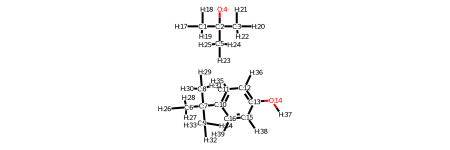

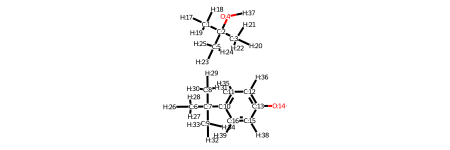

In [18]:
r_smi, p_smi = rxn_smiles.split(">>")
r_mol = RDKitMol.FromSmiles(r_smi)
p_mol = RDKitMol.FromSmiles(p_smi)
display(r_mol, p_mol)

In [19]:
trained_model_dir = "../../ts_egnn/trained_models/ts_egnn/2022_02_07_fixed"
embedder = TSEGNNGuesser(trained_model_dir, track_stats=True)

# trained_model_dir = "../../ts_egnn/trained_models/ts_gcn/2022_03_18/"
# embedder = TSGCNGuesser(trained_model_dir, track_stats=True)

# embedder = RMSDPPGuesser(track_stats=True)
# embedder = AutoNEBGuesser(track_stats=True)

ts_gen = TSConformerGenerator(
    rxn_smiles=rxn_smiles,
    embedder=embedder,
    optimizer=SellaOptimizer(track_stats=True, steps=300),
    pruner=TorsionPruner(),
    verifiers=[XTBFrequencyVerifier(track_stats=True)],
    save_dir="./test_ts",
    multiplicity=r_mol.GetSpinMultiplicity(),
    
)

In [20]:
opt_ts_mol = ts_gen(5)

2022/04/25 06:24:44 PM | TSConformerGenerator | INFO: Embedding stable species conformers...
2022/04/25 06:24:44 PM | StochasticConformerGenerator | INFO: Config specified: using default settings for loose config
2022/04/25 06:24:44 PM | StochasticConformerGenerator | INFO: Generating conformers for [C:1]([C:2]([C:3]([H:20])([H:21])[H:22])([O:4])[C:5]([H:23])([H:24])[H:25])([H:17])([H:18])[H:19]
2022/04/25 06:24:44 PM | StochasticConformerGenerator | INFO: 
Iteration 1: embedding 20 initial guesses...
2022/04/25 06:24:44 PM | StochasticConformerGenerator | INFO: Iteration 1: optimizing initial guesses...
2022/04/25 06:24:45 PM | StochasticConformerGenerator | INFO: Iteration 1: pruning conformers...
2022/04/25 06:24:45 PM | StochasticConformerGenerator | INFO: Iteration 1: kept 15 unique conformers
2022/04/25 06:24:45 PM | StochasticConformerGenerator | INFO: 
Iteration 2: embedding 20 initial guesses...
2022/04/25 06:24:45 PM | StochasticConformerGenerator | INFO: Iteration 2: optimiz

2022/04/25 06:25:00 PM | StochasticConformerGenerator | INFO: 
Iteration 4: embedding 20 initial guesses...
2022/04/25 06:25:00 PM | StochasticConformerGenerator | INFO: Iteration 4: optimizing initial guesses...
2022/04/25 06:25:00 PM | StochasticConformerGenerator | INFO: Iteration 4: pruning conformers...
2022/04/25 06:25:00 PM | StochasticConformerGenerator | INFO: Iteration 4: kept 51 unique conformers
2022/04/25 06:25:00 PM | StochasticConformerGenerator | INFO: 
Iteration 5: embedding 20 initial guesses...
2022/04/25 06:25:00 PM | StochasticConformerGenerator | INFO: Iteration 5: optimizing initial guesses...
2022/04/25 06:25:01 PM | StochasticConformerGenerator | INFO: Iteration 5: pruning conformers...
2022/04/25 06:25:01 PM | StochasticConformerGenerator | INFO: Iteration 5: kept 57 unique conformers
2022/04/25 06:25:01 PM | StochasticConformerGenerator | INFO: 
Iteration 6: embedding 20 initial guesses...
2022/04/25 06:25:01 PM | StochasticConformerGenerator | INFO: Iteratio

In [13]:
initial_guess_mol = RDKitMol.FromFile("./test_ts/ts_initial_guess_confs.sdf", sameMol=True)
# initial_guess_mol = RDKitMol.FromFile("/home/lagnajit/test3/ts_initial_guess_confs.sdf", sameMol=True)
interactive_conformer_viewer(initial_guess_mol)

interactive(children=(IntSlider(value=0, description='confId', max=4), Output()), _dom_classes=('widget-intera…

<function rdmc.view.interactive_conformer_viewer.<locals>.<lambda>(confId)>

In [14]:
opt_ts_mol = RDKitMol.FromFile("./test_ts/ts_optimized_confs.sdf", sameMol=True)
# opt_ts_mol = RDKitMol.FromFile("/home/lagnajit/test3/ts_optimized_confs.sdf", sameMol=True)
interactive_conformer_viewer(opt_ts_mol)

interactive(children=(IntSlider(value=0, description='confId', max=4), Output()), _dom_classes=('widget-intera…

<function rdmc.view.interactive_conformer_viewer.<locals>.<lambda>(confId)>

In [6]:
import pickle

test_dir = "/home/lagnajit/test3/"
freq_path = os.path.join(test_dir, "freq_check_ids.pkl")
irc_path = os.path.join(test_dir, "irc_check_ids.pkl")
workflow_path = os.path.join(test_dir, "workflow_check_ids.pkl")

with open(freq_path, "rb") as f:
    freq_check = pickle.load(f)
with open(irc_path, "rb") as f:
    irc_check = pickle.load(f)
with open(workflow_path, "rb") as f:
    workflow_check = pickle.load(f)

print(freq_check)
print(irc_check)
print(workflow_check)

[True, True, True, True, False, True, True, False, False, False]
[True, True, True, False, False, True, True, False, False, False]
{0: True, 1: True, 2: True, 3: False, 4: False, 5: True, 6: True, 7: False, 8: False, 9: False, 10: True, 11: False, 12: False, 13: True, 14: True, 15: False, 16: True, 17: False, 18: False, 19: False}


In [ ]:
opt_ts_mol.KeepIDs

In [ ]:
keep_ids = {i: True for i in range(opt_ts_mol.GetNumConformers())}
energies = {i: i for i in range(opt_ts_mol.GetNumConformers())}
opt_ts_mol.KeepIDs = keep_ids
opt_ts_mol.Energies = energies
# setattr(opt_ts_mol._mol, "KeepIDs", keep_ids)

opt_ts_mol.KeepIDs[0] = False
opt_ts_mol.KeepIDs

In [ ]:
copied_mol = opt_ts_mol.Copy(quickCopy=True, copy_attrs=["KeepIDs", "Energies"])
copied_mol.KeepIDs
copied_mol.Energies

In [ ]:
copied_mol.KeepIDs[1] = False
opt_ts_mol.KeepIDs

In [ ]:
from rdmc.conformer_generation.utils import mol_to_dict, dict_to_mol

In [ ]:
mol_dict = mol_to_dict(opt_ts_mol, conf_copy_attrs=["KeepIDs", "Energies"])
mol_dict

In [ ]:
d2m_mol = dict_to_mol(mol_dict, conf_copy_attrs=["KeepIDs", "Energies"])
d2m_mol.Energies

In [ ]:
opt_ts_mol.KeepIDs
unique_ids = [0, 1, 2, 3, 4, 6]



In [ ]:
import pickle

with open("/home/lagnajit/Downloads/0/0/freq_check_ids.pkl", "rb") as f:
    freq_check = pickle.load(f)
    
freq_check

In [ ]:
import pickle

with open("./test_ts/freq_check_ids.pkl", "rb") as f:
    freq_check = pickle.load(f)
    
print(freq_check)


with open("./test_ts/workflow_check_ids.pkl", "rb") as f:
    full_check = pickle.load(f)
    
print(full_check)

In [ ]:
for i in range(opt_ts_mol.GetNumConformers()):
    save_dir = os.path.join("./test_ts", f"sella_opt{i}")
    props = run_xtb_calc(opt_ts_mol, confId=i, job="--hess", save_dir=save_dir)
    print(props["frequencies"][:5])

In [ ]:
opt_ts_mol = RDKitMol.FromFile("../../../../Windows/Papers/ts2/scheme_examples/ts_initial_guess_confs_fig.sdf", sameMol=True)
interactive_conformer_viewer(opt_ts_mol)

In [ ]:
# check some examples
save_dir = "../rdmc/conformer_exps/ts_conf_gen/exps/val_rxns_egnn/1000/"
r_file = os.path.join(save_dir, "reactant_confs.sdf")
p_file = os.path.join(save_dir, "product_confs.sdf")
ts_guess_file = os.path.join(save_dir, "ts_initial_guess_confs.sdf")
ts_opt_file = os.path.join(save_dir, "ts_optimized_confs.sdf")
freq_ver_file = os.path.join(save_dir, "freq_check_ids.pkl")
irc_ver_file = os.path.join(save_dir, "irc_check_ids.pkl")

with open(freq_ver_file, "rb") as f:
    freq_ids = pickle.load(f)
print(freq_ids)

with open(irc_ver_file, "rb") as f:
    irc_ids = pickle.load(f)
print(irc_ids)

guess_ts = RDKitMol.FromFile(ts_guess_file, sanitize=False, sameMol=True)
opt_ts = RDKitMol.FromFile(ts_opt_file, sanitize=False, sameMol=True)

interactive_conformer_viewer(guess_ts)
interactive_conformer_viewer(opt_ts)

In [ ]:
# make things look pretty with pymol

# distance d1, o1, h1
# hide labels, d1

# unbond c2, o1
# distance d2, c2, o1
# hide labels, d2

# unbond h1, c1
# distance d3, h1, c1
# hide labels, d3

# set dash_color, white
# set dash_gap, 0.15
# set dash_radius, 0.03

In [ ]:
# allow old models with pyg 1.7 to be compatible with new pyg 2.0
# layernorm was incorrectly implemented, so we need to change the shape
# of any "node_norm" weights/biases from [1] to [hidden_dim]
# previously, this meant that weights/biases in layernorm were incorrectly broadcasted

# import torch
# from copy import deepcopy

# trained_model_dir = "../../ts_egnn/trained_models/ts_egnn/2022_02_07"
# old_model = torch.load(os.path.join(trained_model_dir, "best_model.ckpt"))

# new_state_dict = deepcopy(old_model["state_dict"])
# for param in new_state_dict:
#     if "node_norm" in param:
#         new_param = new_state_dict[param] * torch.ones([64])
#         new_state_dict[param] = new_param
        
# old_model["state_dict"] = new_state_dict